## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI3D-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'ddd'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
ddd_wavelet_full_syntheticMRI3D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/ddd'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0, 3: 564, 4: 22538, 5: 296776, 6: 2880648, 7: 25362406, 8: 213093688}

Running 12760 CDFs


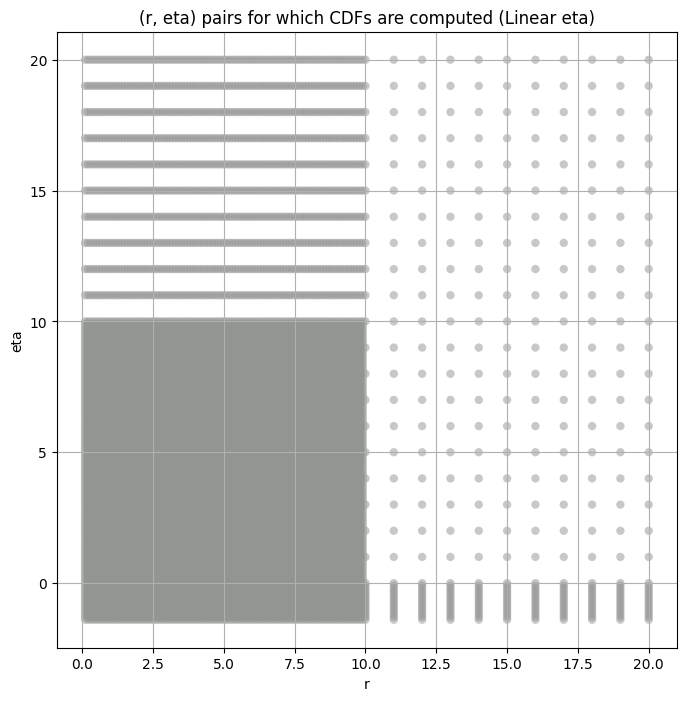

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                        
2                NaN           NaN            NaN          NaN         NaN   
3      455481.660000  363057.70000  557847.940000     1.944887    1.001270   
4      241418.060000  225806.88000  257381.550000     4.450259    4.034465   
5       33947.695000   31871.59600   36147.625000     3.966855    3.001096   
6        6416.669400    5792.75630    7090.980500    13.477583   10.768813   
7         397.892600     357.50107     450.380680    17.566162    9.929181   
8          14.746988       8.50211      32.184074  1000.201200   10.271237   

        kurt_upper  total_samples  
layer                              
2              NaN            0.0  
3         2.934036          564.0  
4         4.879806        22538.0  
5         5.099455       296776.0  
6        16.435010      2880648.0  
7        54.616486     25362406.0  
8      2363.247800    213093688.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2                NaN            NaN             NaN             NaN   
3      455481.660000  455481.656250   221664.859375   162480.859375   
4      241418.060000  241418.062500   229585.984375   220231.609375   
5       33947.695000   33947.695312    33222.949219    32678.148438   
6        6416.669400    6416.669434     6168.574219     5979.792480   
7         397.892600     397.892609      378.572418      367.015778   
8          14.746988      14.746988        8.503249        8.196498   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       119545.007812     86850.812500     43662.214844     16241.754883   
4       211534.531250    203526.859375    188997.781250    176422.359375   
5        32216.314453     31811.285156     31109.050781     30505.232422   
6         5819.041504      5677.265625      5431.959473      5223.827637   
7          357.397461       349.053833       334.934326       323.138672   
8            7.983407         7.807825         7.518681         7.279838   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3          2001.553223              NaN              NaN              NaN  
4        165216.343750    155393.984375    146804.500000    127720.843750  
5         29969.990234     29486.429688     29041.425781     27883.861328  
6          5041.256348      4878.927246      4733.074219      4366.747070  
7           312.920898       303.864960       295.714203       275.079315  
8             7.073113         6.889404         6.723287         6.299583

####
Layer  2
####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.016968576525246082 455481.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05753024806035614 221664.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0928570752099954 162480.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.12662930412560602 119545.01


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.15915067352024892 86850.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.23913941046851162 43662.215


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.31693302632315834 16241.755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.4060059279599649 2001.5532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 nan nan
Number of samples: 564, Without approximation : 564.0


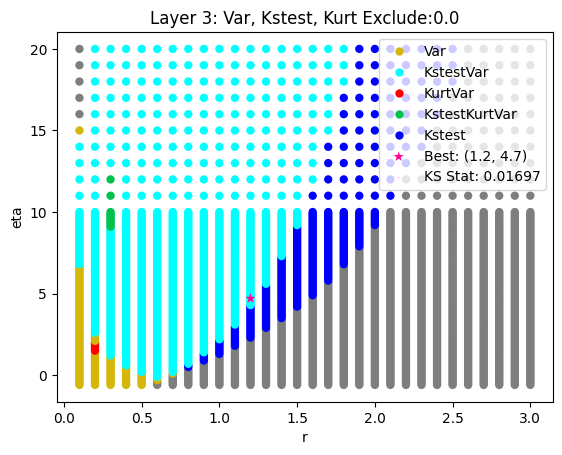

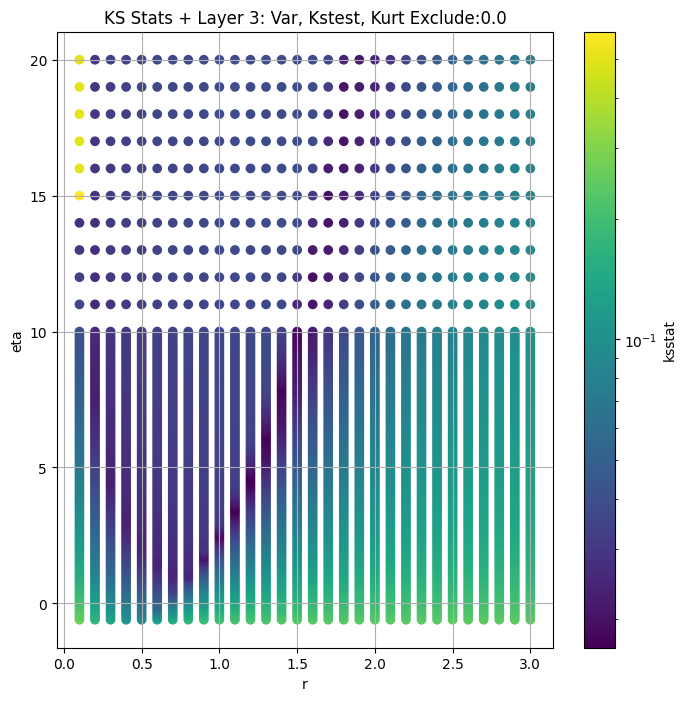

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.007677904751060449 241418.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007739660247618851 229585.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.010854687496976156 220231.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.011143919224920001 211534.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.012287792125028896 203526.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.014508541295396582 188997.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.017996283552870418 176422.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.019889269778777544 165216.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.022616723766831437 155393.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.025617765648719537 146804.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.033704016688275204 127720.84
Number of samples: 22538, Without approximation : 22538.0


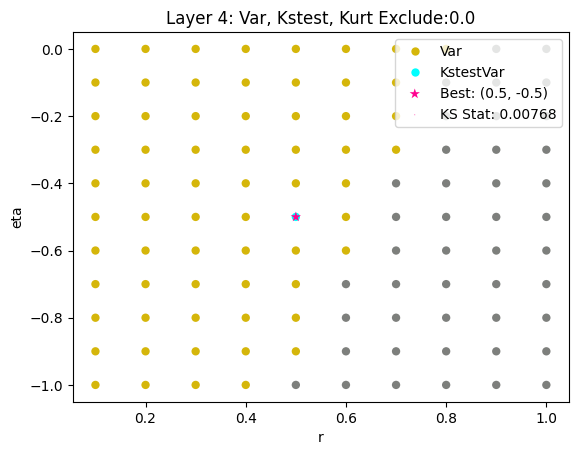

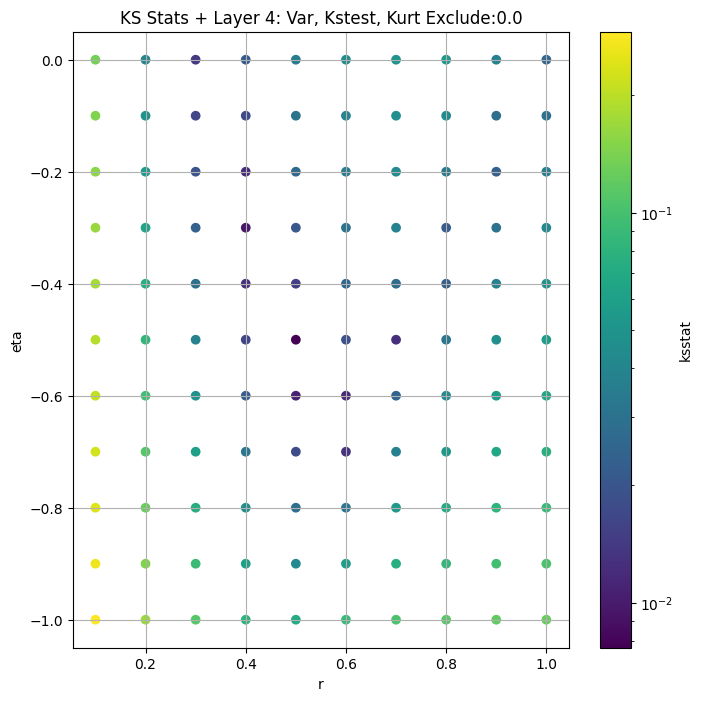

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0011299610430014484 33947.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0012302366891145944 33222.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.0015053531666028297 32678.148


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0018333578444724788 32216.314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.002211839638152413 31811.285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0029219115581408106 31109.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0035604676675999 30505.232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004209218853426294 29969.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.004845891822391098 29486.43


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.005492505553171045 29041.426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007162155175274541 27883.861
Number of samples: 100000, Without approximation : 296776.0


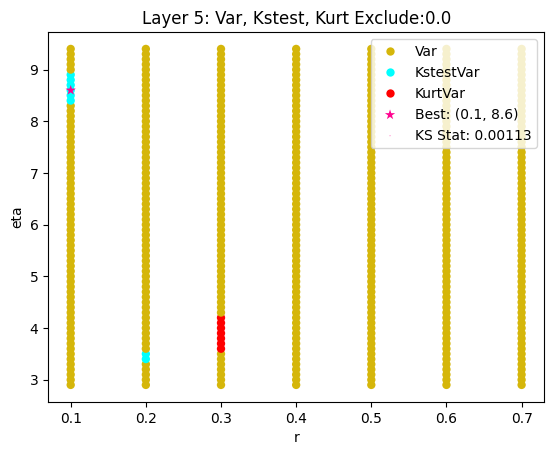

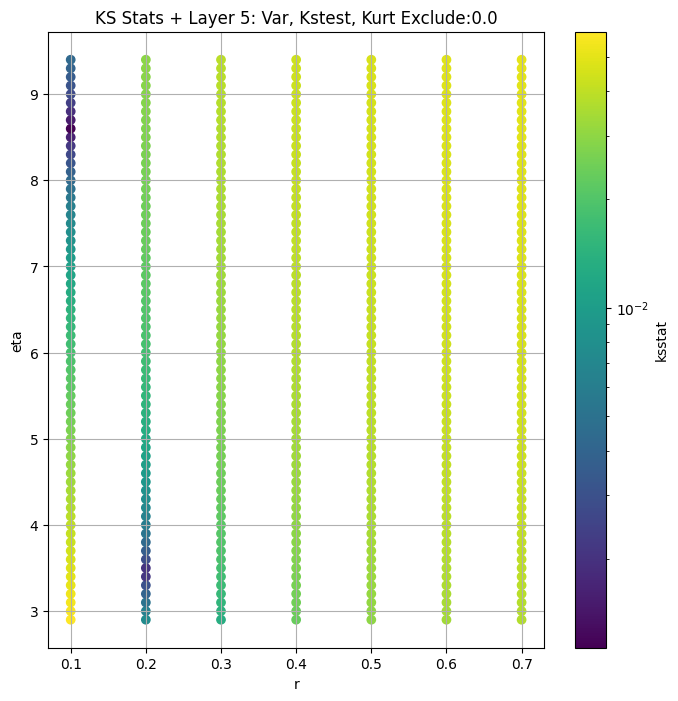

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.010357635739462634 6416.6694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009443136606464897 6168.574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.00834301717442959 5979.7925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.007898968707042334 5819.0415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006969573087920455 5677.2656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006042844731100616 5431.9595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.005112477492978884 5223.8276


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.004906222097544544 5041.2563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.005450300275671517 4878.9272


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.005918611125088291 4733.074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.007564998386449084 4366.747
Number of samples: 100000, Without approximation : 2880648.0


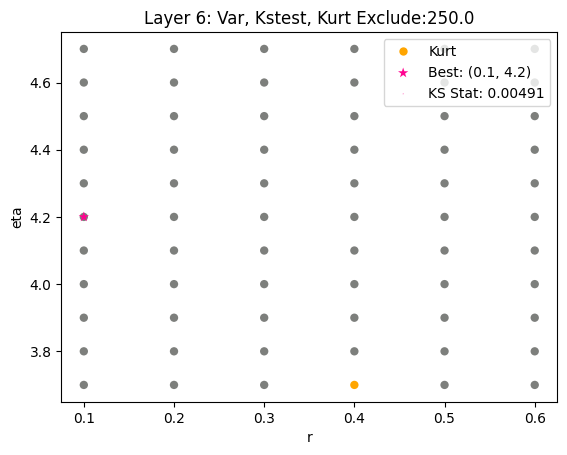

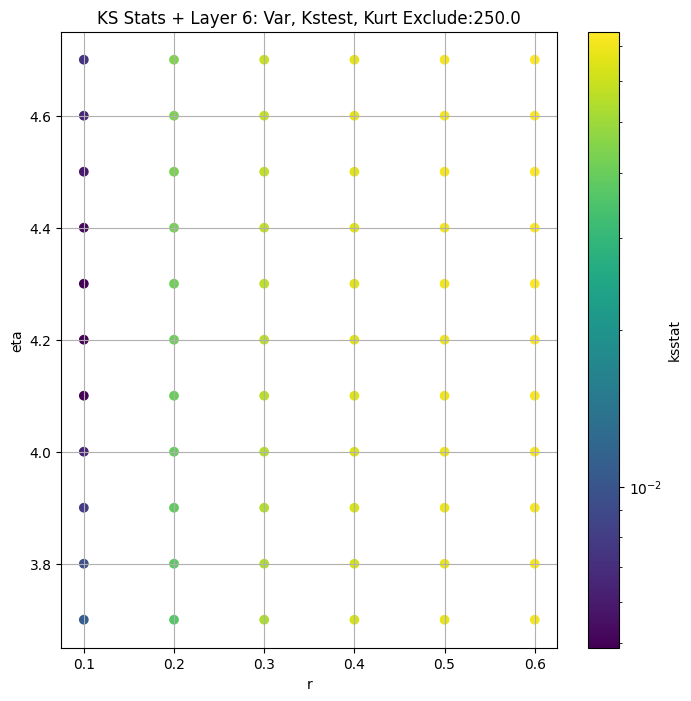

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.003810760426765203 397.8926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.0028709124408590747 378.57242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.003379362442656575 367.01578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.003992199893009363 357.39746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.003779382543075749 349.05383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.004771082866605991 334.93433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.005095747827646324 323.13867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0059193022650618765 312.9209


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.006314706886472891 303.86496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.00674950008748354 295.7142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.008507013671560613 275.0793
Number of samples: 100000, Without approximation : 25362406.0


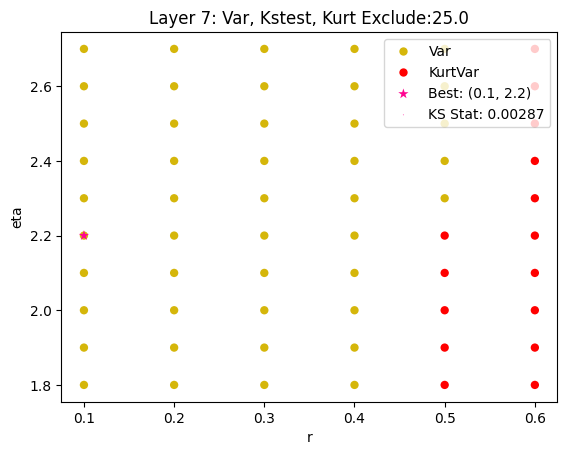

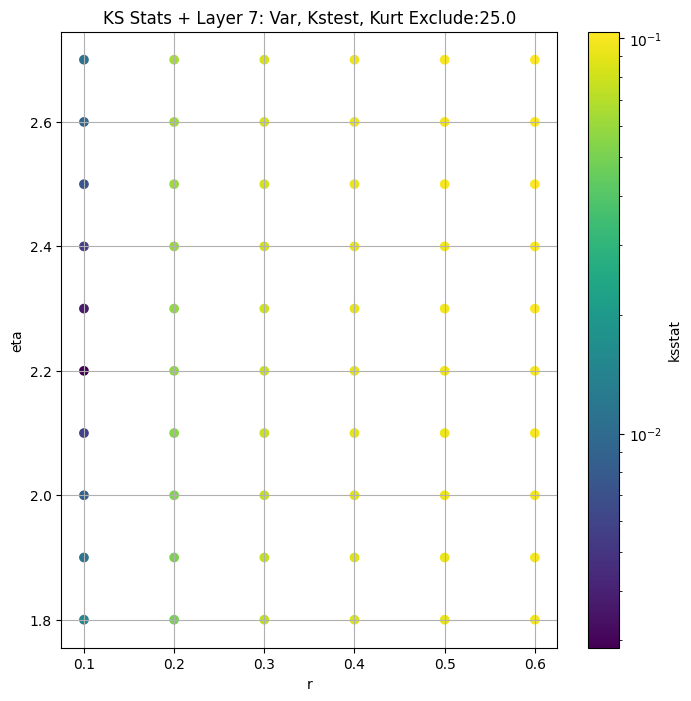

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.013754332567610383 14.746988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0026355196936136624 8.503249


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.003560457437035043 8.196498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00427377955552799 7.9834065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.003926476932219293 7.807825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.004892817112408854 7.518681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005341519004231854 7.2798376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0056452609401268505 7.073113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006102116316611474 6.889404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.006852285086078012 6.7232866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00869943645777135 6.2995834
Number of samples: 100000, Without approximation : 213093688.0


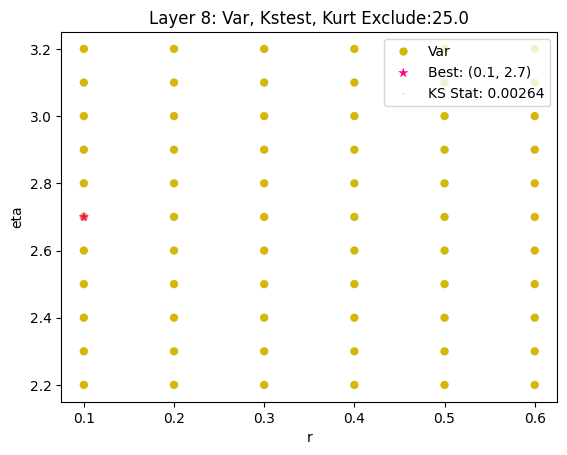

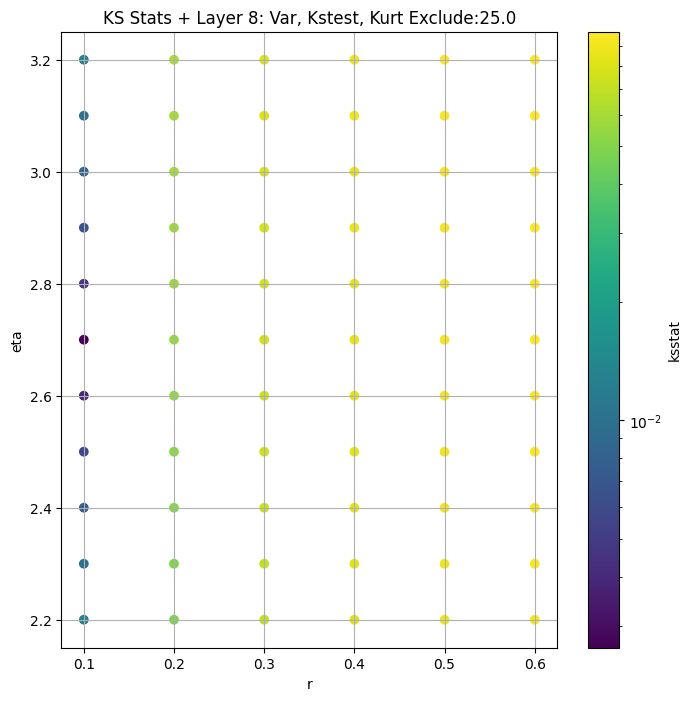

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                        
2                NaN           NaN            NaN          NaN         NaN   
3      455481.660000  363057.70000  557847.940000     1.944887    1.001270   
4      241418.060000  225806.88000  257381.550000     4.450259    4.034465   
5       33947.695000   31871.59600   36147.625000     3.966855    3.001096   
6        6416.669400    5792.75630    7090.980500    13.477583   10.768813   
7         397.892600     357.50107     450.380680    17.566162    9.929181   
8          14.746988       8.50211      32.184074  1000.201200   10.271237   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN            0.0                  NaN        NaN   
3         2.934036          564.0             0.016969        1.2   
4         4.879806        22538.0             0.007678        0.5   
5         5.099455       296776.0             0.001130        0.1   
6        16.435010      2880648.0             0.004906        0.1   
7        54.616486     25362406.0             0.002871        0.1   
8      2363.247800    213093688.0             0.002636        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3              4.7   1.000000e+05                     0.0       455481.660000   
4             -0.5   4.023634e+04                     0.0       241418.060000   
5              8.6   1.994786e-16                     0.0        33947.695000   
6              4.2   6.584660e-15                   250.0         5041.256300   
7              2.2   2.559260e-14                    25.0          378.572420   
8              2.7   1.833871e-16                    25.0            8.503249   

       kstest_stat_cutoff_0.05  
layer                           
2                          NaN  
3                     0.056882  
4                     0.009039  
5                     0.002492  
6                     0.000800  
7                     0.000270  
8                     0.000093

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.16450760615118554, var: 86850.8125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.12858384347217228, var: 119545.0078125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.09611069255109517, var: 162480.859375


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.060581398584386936, var: 221664.859375


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.016692766188877856, var: 455481.65625
Number of samples: 564, Without approximation : 564.0


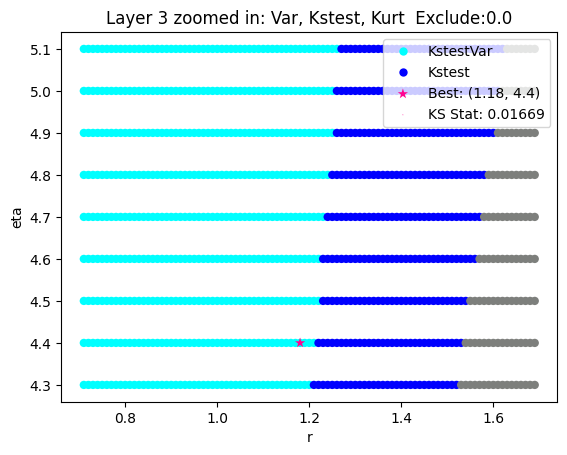

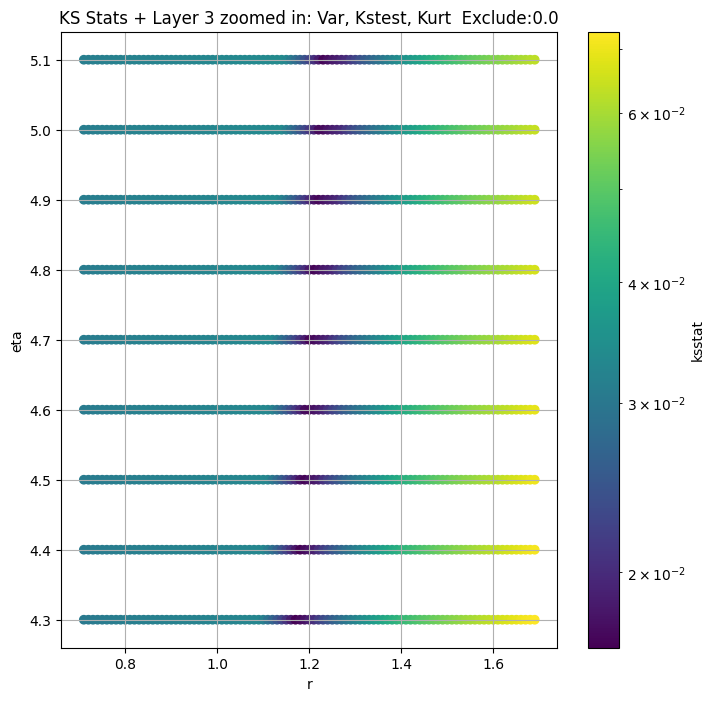

Layer 4


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.01168439883081894, var: 203526.859375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.010712397956859854, var: 211534.53125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.00913104415166921, var: 220231.609375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.007739660247618851, var: 229585.984375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.006549432817656672, var: 241418.0625
Number of samples: 22538, Without approximation : 22538.0


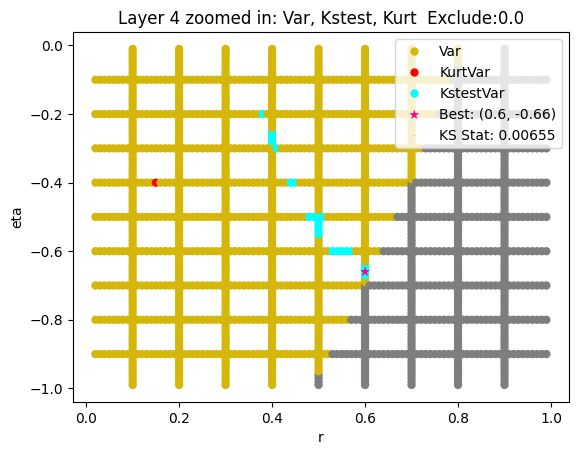

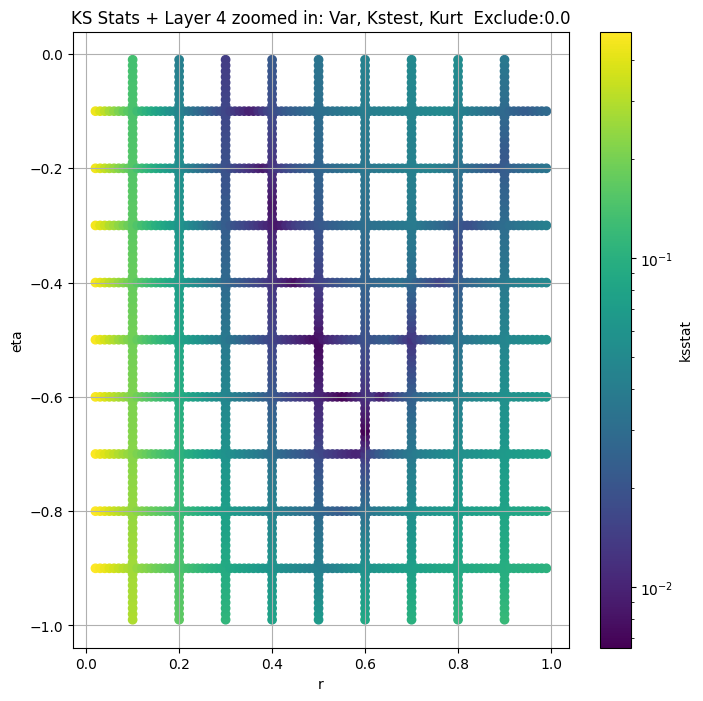

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0029925646288850513, var: 31811.28515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.002399587162052165, var: 32216.314453125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0018406064382779017, var: 32678.1484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0012693670907966276, var: 33222.94921875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0011299610430014484, var: 33947.6953125
Number of samples: 100000, Without approximation : 296776.0


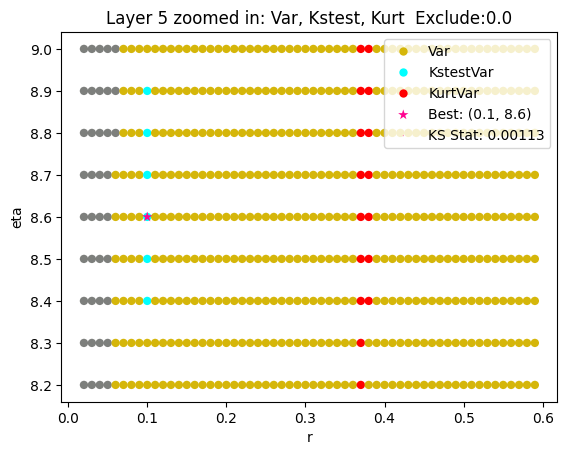

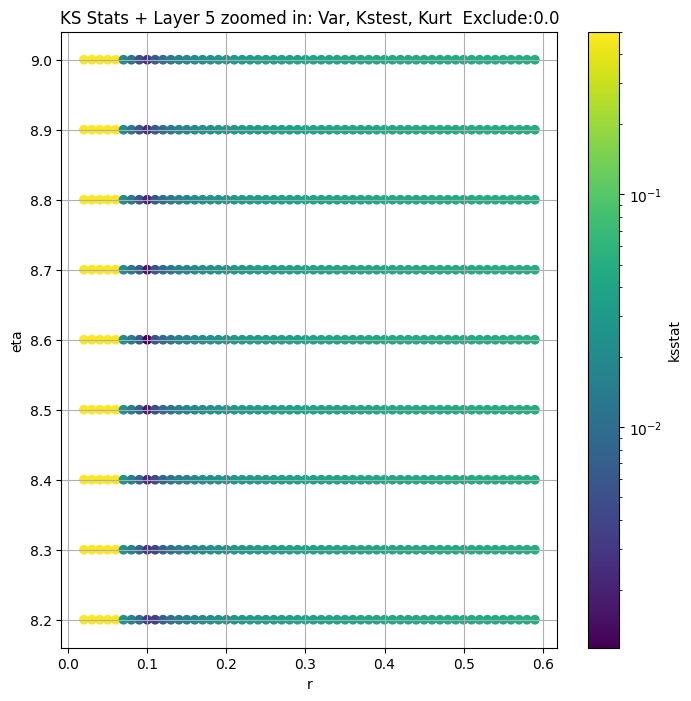

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.0060254394797122305, var: 4733.07421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.005717673679662574, var: 4804.1103515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.005450300275671517, var: 4878.92724609375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.005159190081343912, var: 4957.70947265625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.004906222097544544, var: 5041.25634765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.004629300931736302, var: 5129.94970703125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.004852024177201555, var: 5223.82763671875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.005302808604158604, var: 5324.17333984375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.005815272399460336, var: 5431.95947265625
Number of samples: 100000, Without approximation : 2880648.0


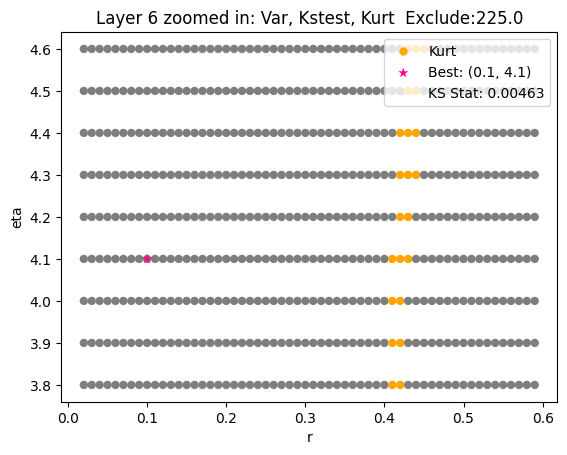

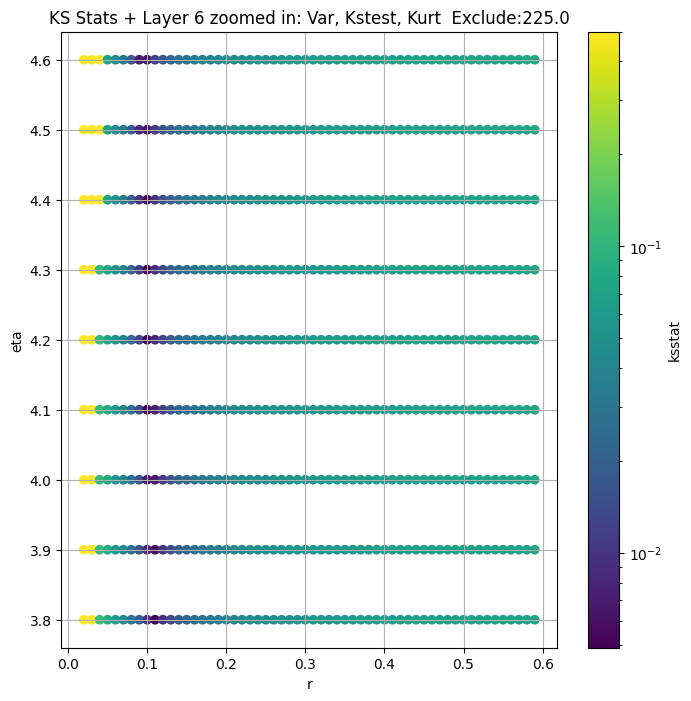

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.004822512676031621, var: 341.64166259765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.0043329396778207935, var: 349.0538330078125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.0037965983903330836, var: 357.3974609375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.003308857058267778, var: 367.0157775878906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.0028709124408590747, var: 378.5724182128906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.0030841447963980695, var: 397.8926086425781
Number of samples: 100000, Without approximation : 25362406.0


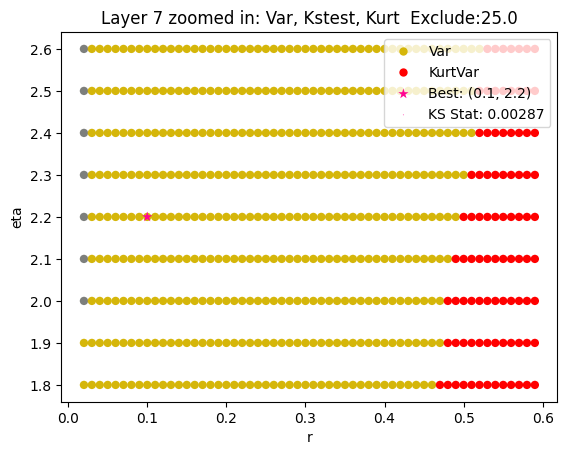

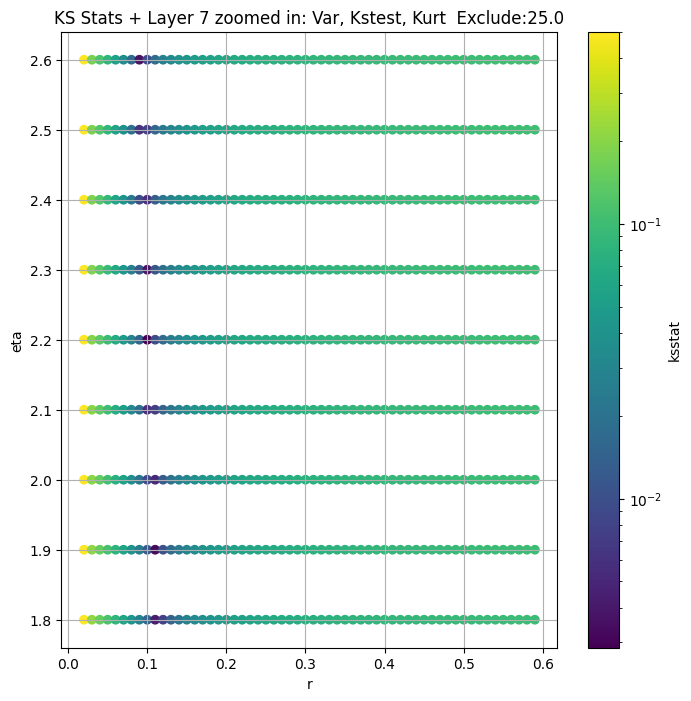

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.005280064163038632, var: 7.655146598815918


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.004735884490366438, var: 7.807825088500977


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.004156071109041801, var: 7.9834065437316895


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.003560457437035043, var: 8.196497917175293


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0026355196936136624, var: 8.503249168395996


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.011790188081050673, var: 14.746988296508789
Number of samples: 100000, Without approximation : 213093688.0


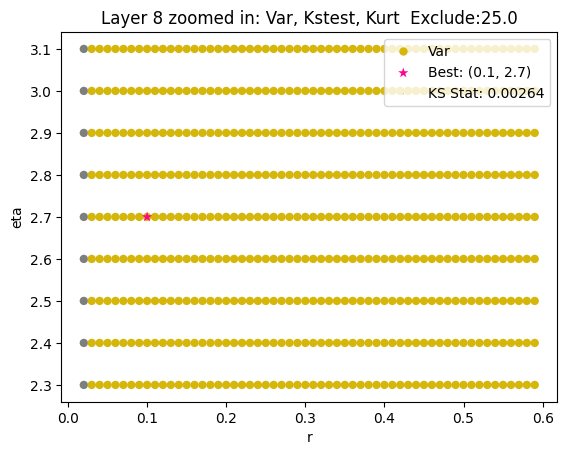

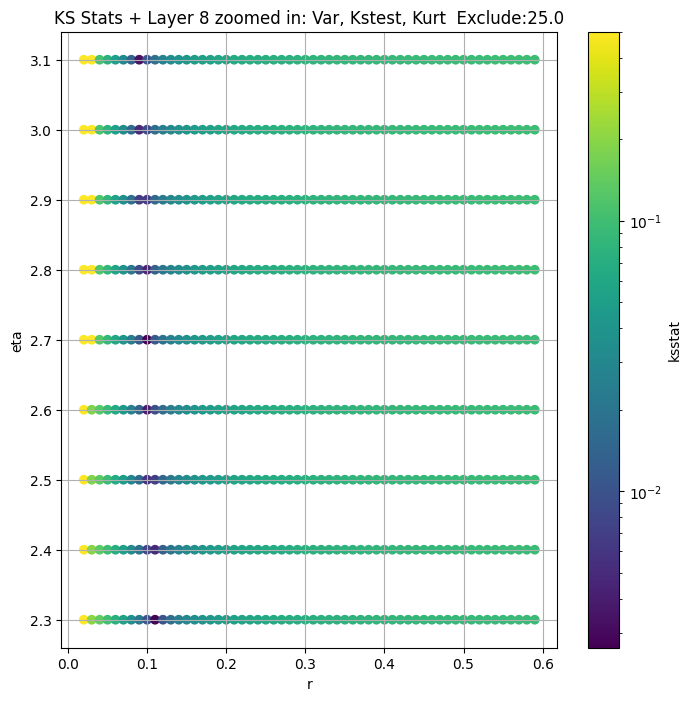

Cannot compute pval with ksstat : nan, n : 0.0


obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                        
2                NaN           NaN            NaN          NaN         NaN   
3      455481.660000  363057.70000  557847.940000     1.944887    1.001270   
4      241418.060000  225806.88000  257381.550000     4.450259    4.034465   
5       33947.695000   31871.59600   36147.625000     3.966855    3.001096   
6        6416.669400    5792.75630    7090.980500    13.477583   10.768813   
7         397.892600     357.50107     450.380680    17.566162    9.929181   
8          14.746988       8.50211      32.184074  1000.201200   10.271237   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN            0.0                  NaN        NaN   
3         2.934036          564.0             0.016969        1.2   
4         4.879806        22538.0             0.007678        0.5   
5         5.099455       296776.0             0.001130        0.1   
6        16.435010      2880648.0             0.004906        0.1   
7        54.616486     25362406.0             0.002871        0.1   
8      2363.247800    213093688.0             0.002636        0.1   

       initial_eta  initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                                           
2              NaN            NaN                     NaN                 NaN   
3              4.7   1.000000e+05                     0.0       455481.656250   
4             -0.5   4.023634e+04                     0.0       241418.062500   
5              8.6   1.994786e-16                     0.0        33947.695000   
6              4.2   6.584660e-15                   250.0         5129.949707   
7              2.2   2.559260e-14                    25.0          378.572420   
8              2.7   1.833871e-16                    25.0            8.503249   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                          NaN               NaN     NaN       NaN   
3                     0.056882          0.016693    1.18      4.40   
4                     0.009039          0.006549    0.60     -0.66   
5                     0.002492          0.001130    0.10      8.60   
6                     0.000800          0.004629    0.10      4.10   
7                     0.000270          0.002871    0.10      2.20   
8                     0.000093          0.002636    0.10      2.70   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2               NaN                  NaN           -1  
3      1.000000e+05                  0.0         6421  
4      1.000000e+05                  0.0        42786  
5      1.994786e-16                  0.0      1502428  
6      7.897026e-15                225.0        90020  
7      2.559260e-14                 25.0       222910  
8      1.833871e-16                 25.0       263374

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

> In quadgk/vadapt (line 278)
In quadgk (line 204)
In compute_cdf_using_gengamma_with_scale (line 10)


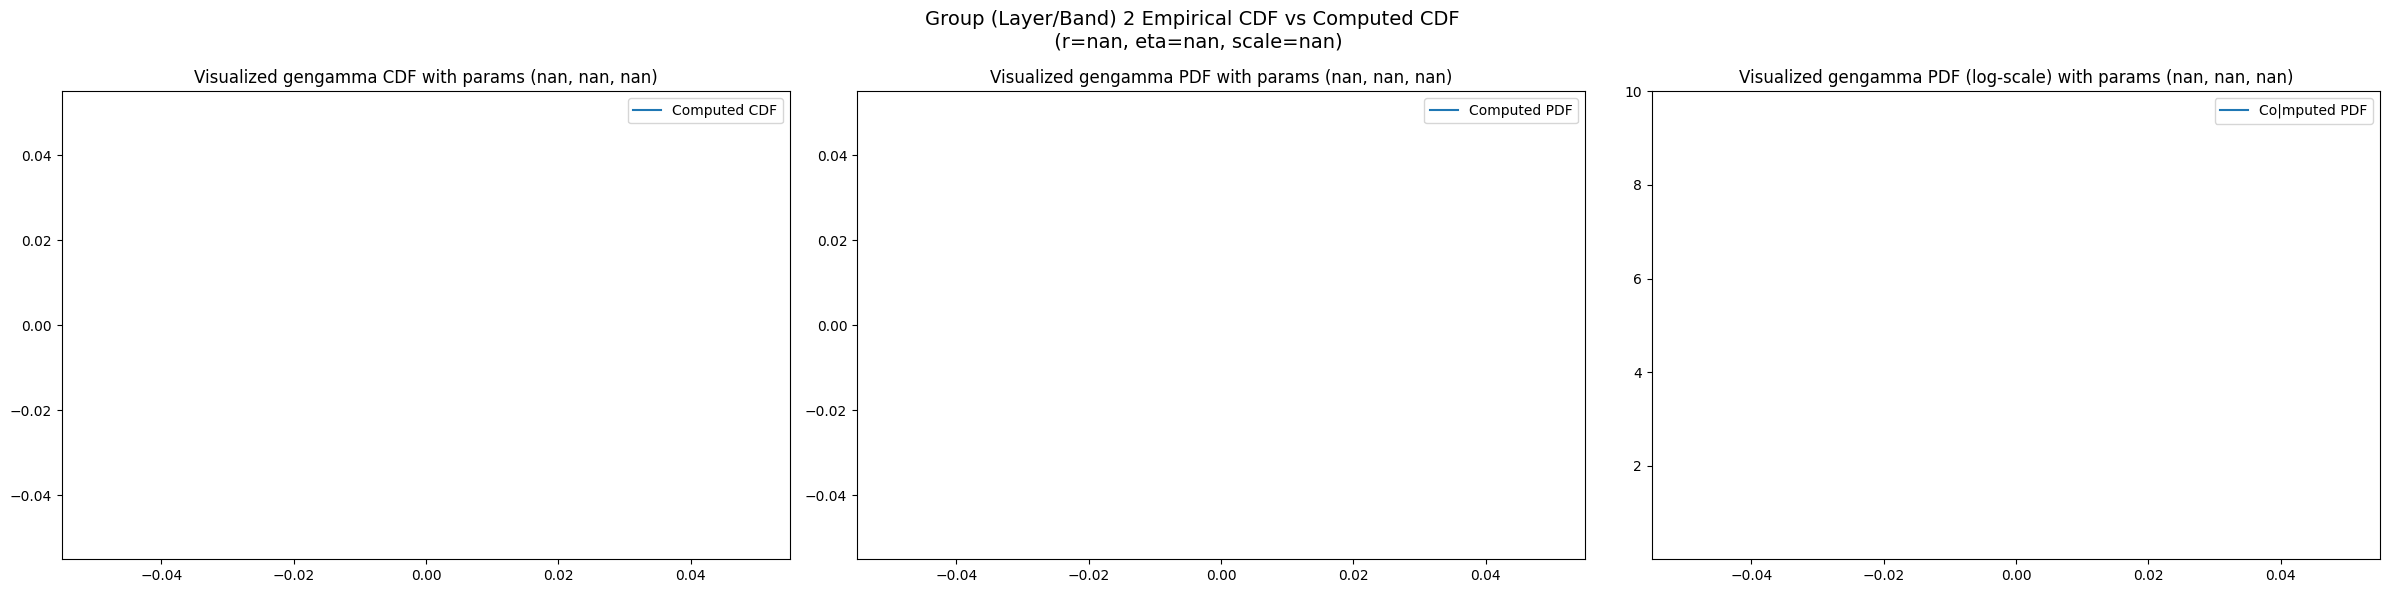

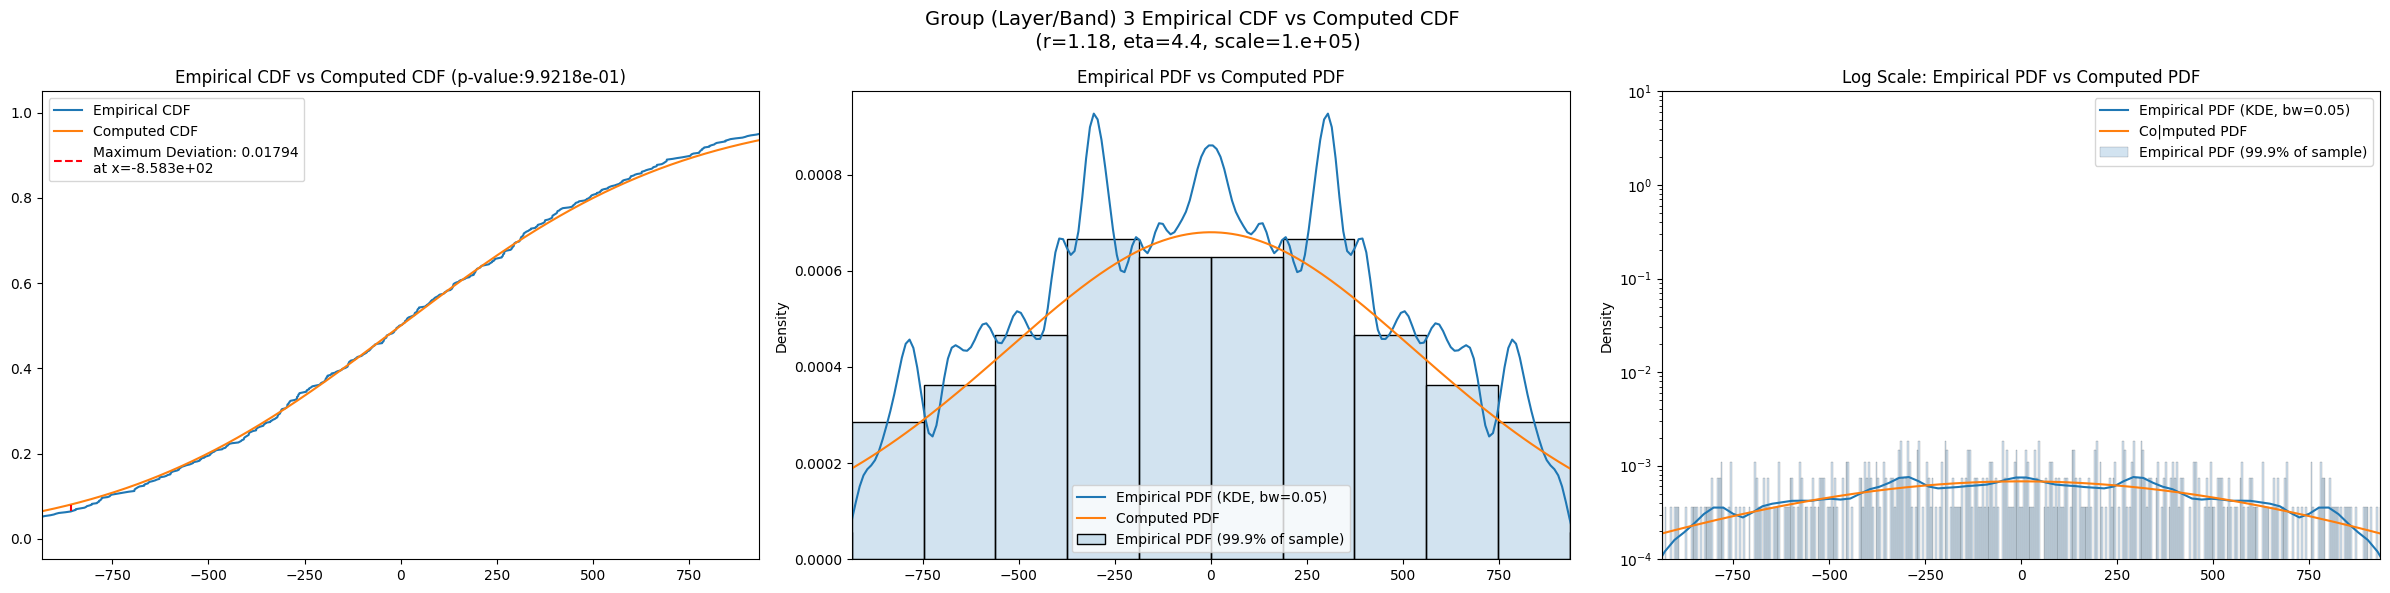

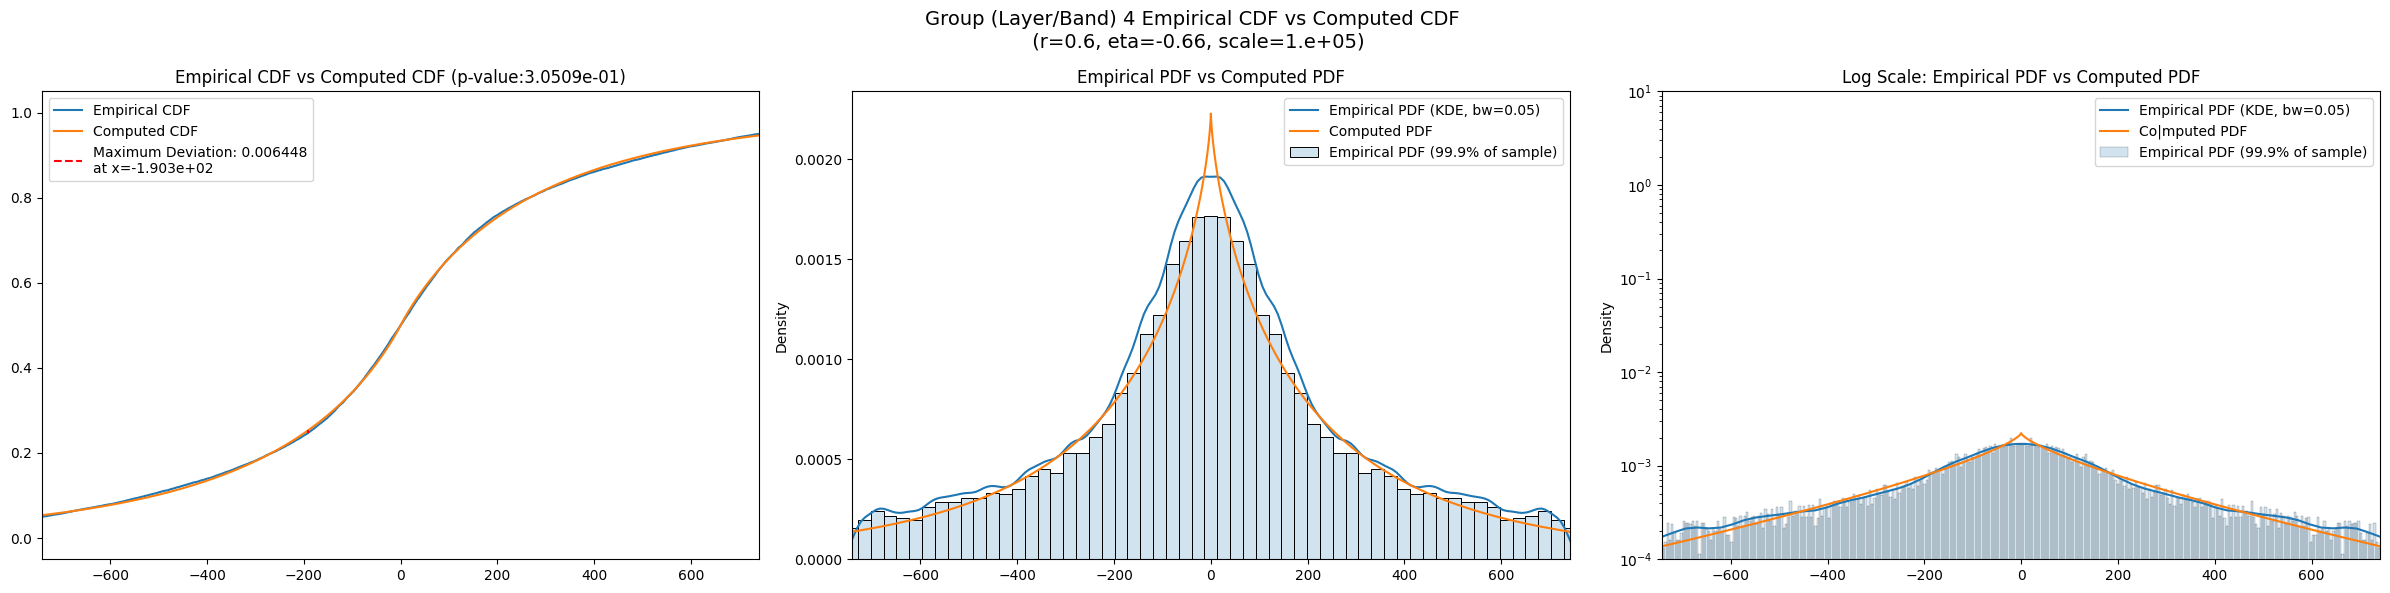

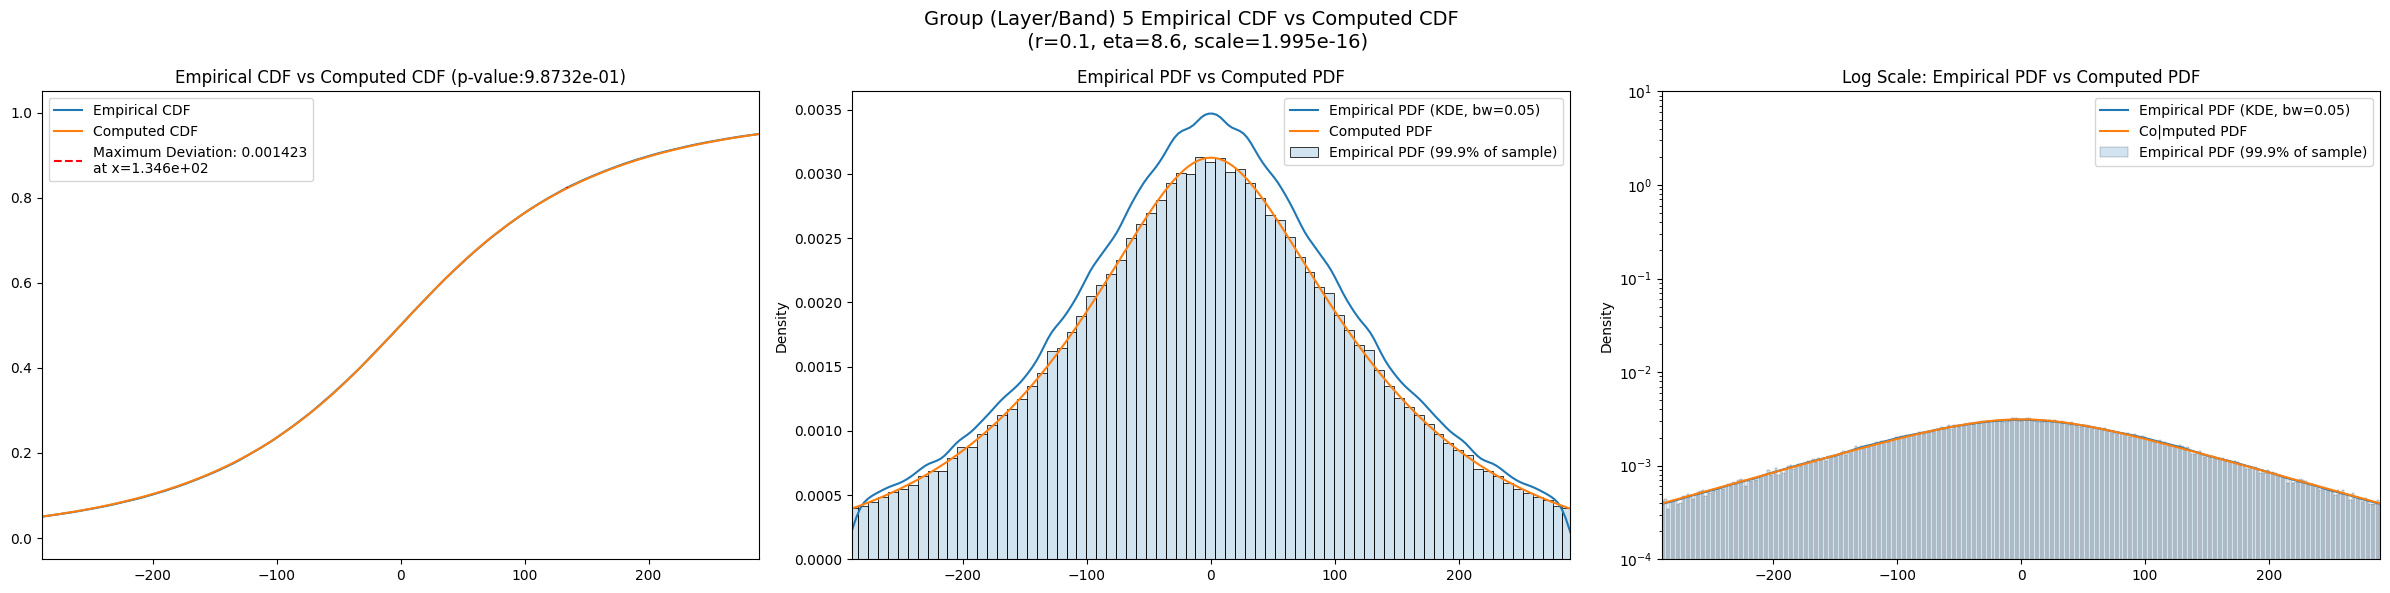

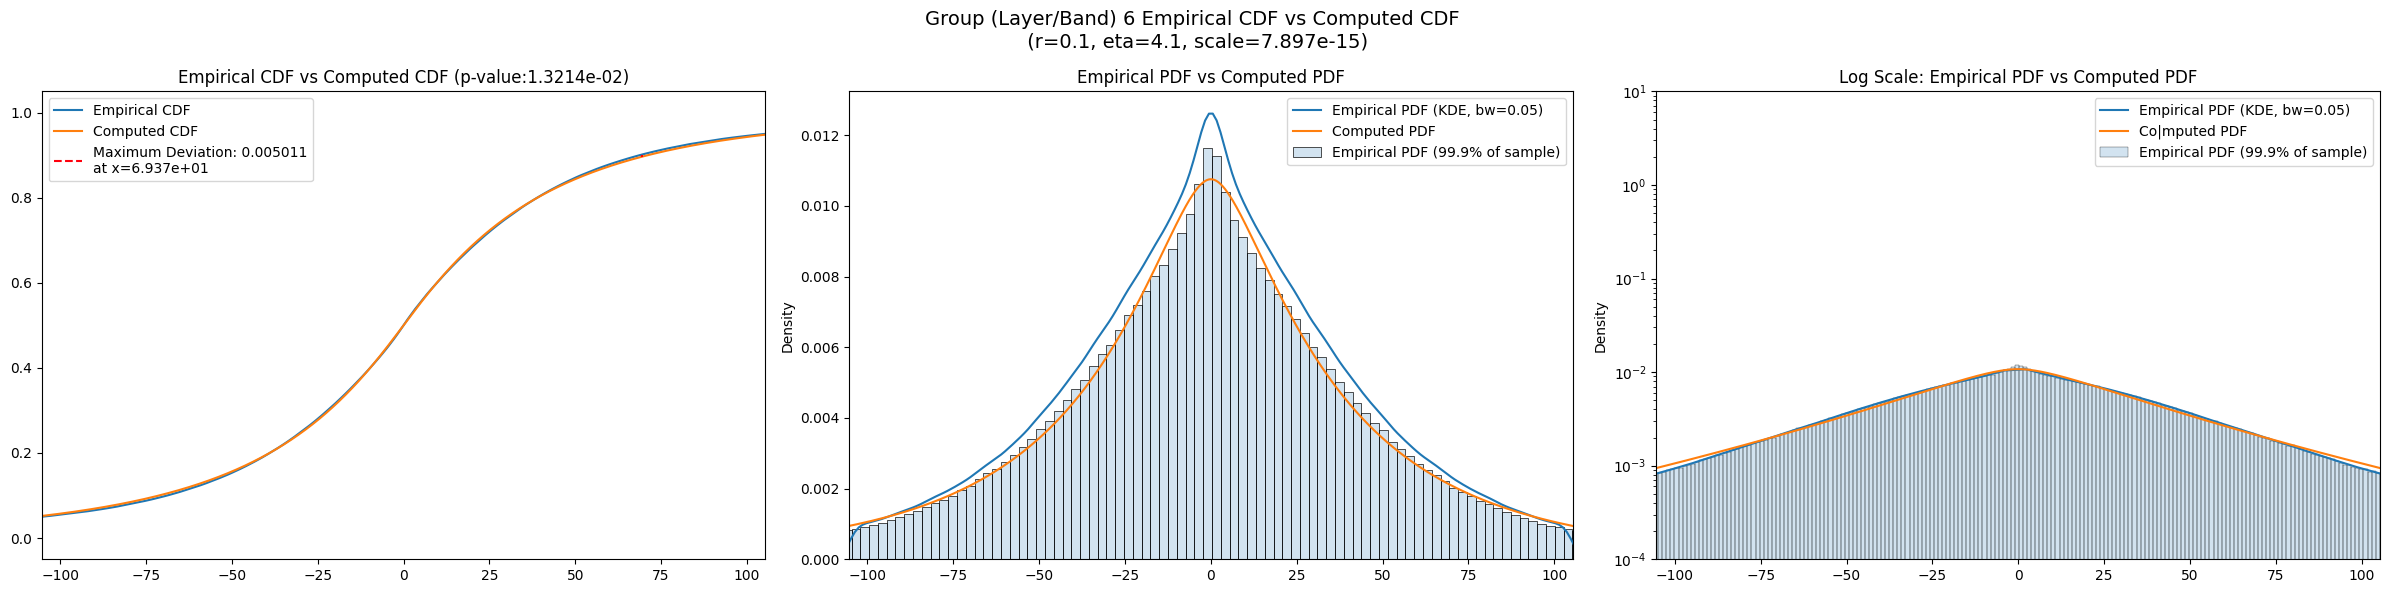

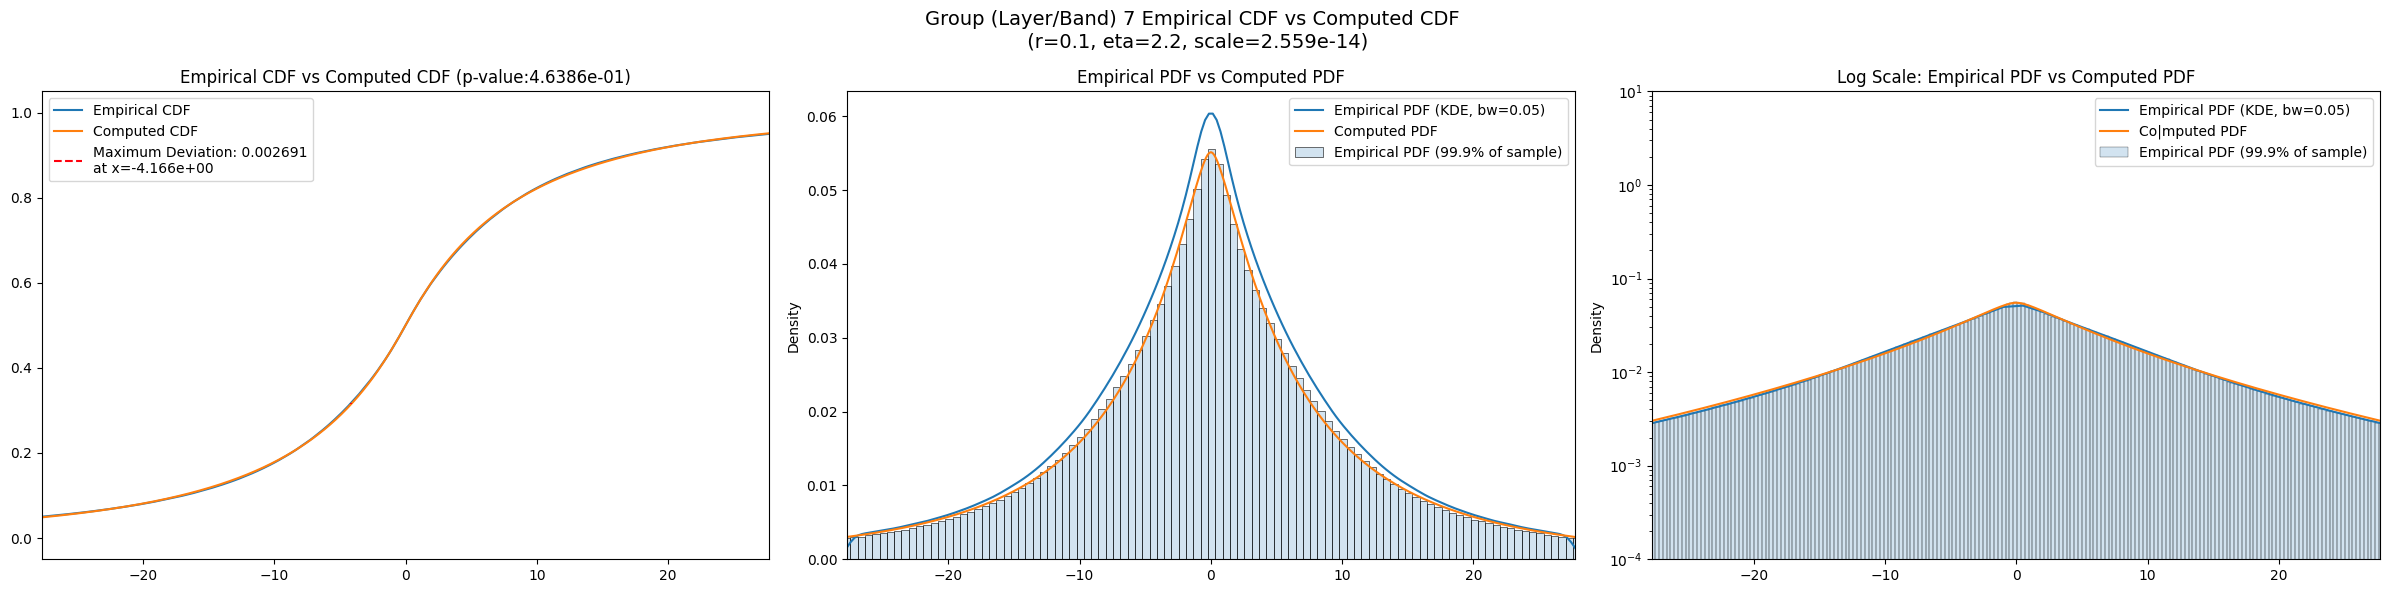

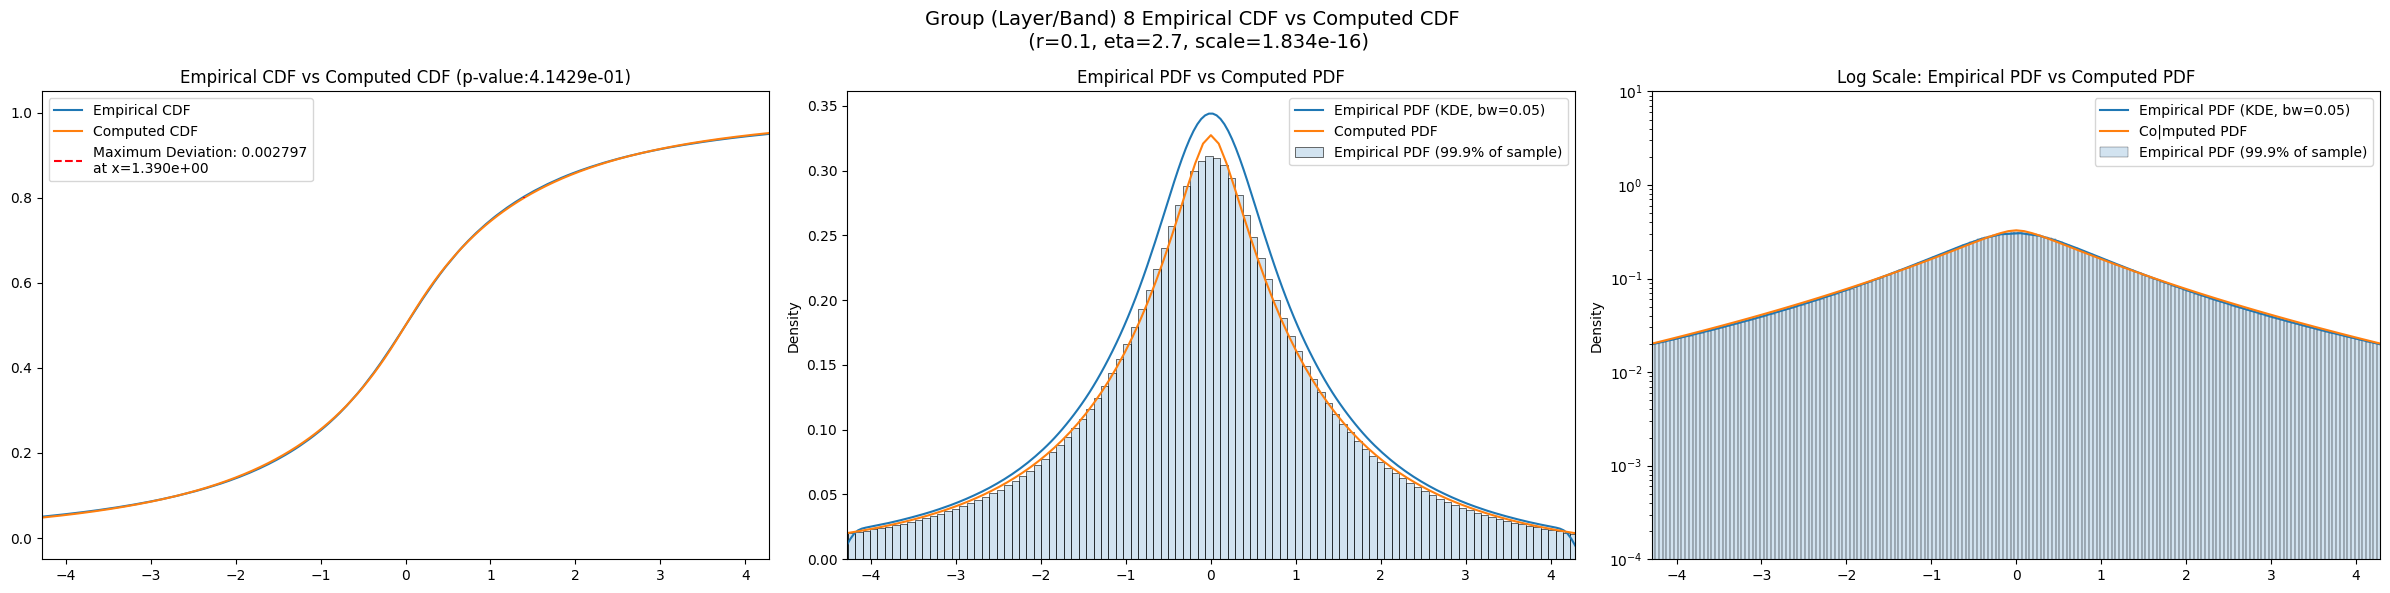

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                        
2                NaN           NaN            NaN          NaN         NaN   
3      455481.660000  363057.70000  557847.940000     1.944887    1.001270   
4      241418.060000  225806.88000  257381.550000     4.450259    4.034465   
5       33947.695000   31871.59600   36147.625000     3.966855    3.001096   
6        6416.669400    5792.75630    7090.980500    13.477583   10.768813   
7         397.892600     357.50107     450.380680    17.566162    9.929181   
8          14.746988       8.50211      32.184074  1000.201200   10.271237   

        kurt_upper  total_samples  kstest_stat_initial  initial_r  \
layer                                                               
2              NaN            0.0                  NaN        NaN   
3         2.934036          564.0             0.016969        1.2   
4         4.879806        22538.0             0.007678        0.5   
5         5.099455       296776.0             0.001130        0.1   
6        16.435010      2880648.0             0.004906        0.1   
7        54.616486     25362406.0             0.002871        0.1   
8      2363.247800    213093688.0             0.002636        0.1   

       initial_eta  ...  param_gaussian  kstest_stat_gaussian  \
layer               ...                                         
2              NaN  ...             NaN                   NaN   
3              4.7  ...       611.71200              0.020127   
4             -0.5  ...       335.61700              0.043631   
5              8.6  ...       152.57700              0.022071   
6              4.2  ...        50.89680              0.031563   
7              2.2  ...        11.62320              0.043327   
8              2.7  ...         1.83375              0.042121   

       kstest_pval_gaussian  param_laplace  kstest_stat_laplace  \
layer                                                             
2                       NaN            NaN                  NaN   
3              9.728620e-01      534.53400             0.036553   
4              1.014740e-37      294.12600             0.016481   
5             5.111040e-126      133.57600             0.009368   
6              0.000000e+00       44.84200             0.010450   
7              0.000000e+00       10.31960             0.017543   
8              0.000000e+00        1.61495             0.015841   

       kstest_pval_laplace    param_t  kstest_stat_t  kstest_pval_t  \
layer                                                                 
2                      NaN        NaN            NaN            NaN   
3             4.281370e-01  446.77500       0.034396   5.059950e-01   
4             9.518220e-06  244.63800       0.019904   3.458100e-08   
5             4.736880e-23  107.61700       0.011334   1.530190e-33   
6            1.197350e-273   35.65140       0.006007   1.010200e-90   
7             0.000000e+00    8.08321       0.015012   0.000000e+00   
8             0.000000e+00    1.29692       0.012936   0.000000e+00   

       kstest_pval_gengamma  
layer                        
2                       NaN  
3              9.968583e-01  
4              2.871511e-01  
5              8.425889e-01  
6              4.771315e-54  
7             5.369889e-182  
8              0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                      NaN                      NaN               NaN   
3                 0.016969                 0.056882          0.016693   
4                 0.007678                 0.009039          0.006549   
5                 0.001130                 0.002492          0.001130   
6                 0.004906                 0.000800          0.004629   
7                 0.002871                 0.000270          0.002871   
8                 0.002636                 0.000093          0.002636   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                       NaN                  NaN            NaN  
3                  0.020127             0.036553       0.034396  
4                  0.043631             0.016481       0.019904  
5                  0.022071             0.009368       0.011334  
6                  0.031563             0.010450       0.006007  
7                  0.043327             0.017543       0.015012  
8                  0.042121             0.015841       0.012936

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2                     NaN               NaN     NaN       NaN           NaN   
3           455481.656250          0.016693    1.18      4.40  1.000000e+05   
4           241418.062500          0.006549    0.60     -0.66  1.000000e+05   
5            33947.695000          0.001130    0.10      8.60  1.994786e-16   
6             5129.949707          0.004629    0.10      4.10  7.897026e-15   
7              378.572420          0.002871    0.10      2.20  2.559260e-14   
8                8.503249          0.002636    0.10      2.70  1.833871e-16   

       best_exclude_cutoff  
layer                       
2                      NaN  
3                      0.0  
4                      0.0  
5                      0.0  
6                    225.0  
7                     25.0  
8                     25.0

In [21]:
eng.quit()